# Random Forest - Classification

## The Data

We will be using the same dataset through our discussions on classification with tree-methods (Decision Tree,Random Forests, and Gradient Boosted Trees) in order to compare performance metrics across these related models.

We will work with the "Palmer Penguins" dataset, as it is simple enough to help us fully understand how changing hyperparameters can change classification results.




Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

Summary:
The data folder contains two CSV files. For intro courses/examples, you probably want to use the first one (penguins_size.csv).

* penguins_size.csv: Simplified data from original penguin data sets. Contains variables:

    * species: penguin species (Chinstrap, Adélie, or Gentoo)
    * culmen_length_mm: culmen length (mm)
    * culmen_depth_mm: culmen depth (mm)
    * flipper_length_mm: flipper length (mm)
    * body_mass_g: body mass (g)
    * island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
    * sex: penguin sex

* (Not used) penguins_lter.csv: Original combined data for 3 penguin species  

Note: The culmen is "the upper ridge of a bird's beak" 

**Our goal is to create a model that can help predict a species of a penguin based on physical attributes, then we can use that model to help researchers classify penguins in the field, instead of needing an experienced biologist**

## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("penguins_size.csv")

In [4]:
df.dropna(inplace=True)
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


## Exploratory Data Analysis and Visualization

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,334.0,43.994311,5.460521,32.1,39.5,44.5,48.575,59.6
culmen_depth_mm,334.0,17.160479,1.967909,13.1,15.6,17.3,18.700,21.5
flipper_length_mm,334.0,201.014970,14.022175,172.0,190.0,197.0,213.000,231.0
body_mass_g,334.0,4209.056886,804.836129,2700.0,3550.0,4050.0,4793.750,6300.0


In [7]:
for i, feature in enumerate(df.select_dtypes("object").columns):
   print(f"{i}.{feature:<7}: {df[feature].unique()}")

# In Sex "." There is an incorrect categorical data. We need to get rid of this.

0.species: ['Adelie' 'Chinstrap' 'Gentoo']
1.island : ['Torgersen' 'Biscoe' 'Dream']
2.sex    : ['MALE' 'FEMALE' '.']


In [8]:
display(df[df["sex"] == "."])
ind = df[df["sex"] == "."].index

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [9]:
df.drop(index=ind, inplace=True)

In [10]:
df.sex.unique()

array(['MALE', 'FEMALE'], dtype=object)

In [11]:
df2 = df.copy()

## Visualization

In [12]:
df["species"].value_counts(normalize=True)

Adelie       0.438438
Gentoo       0.357357
Chinstrap    0.204204
Name: species, dtype: float64

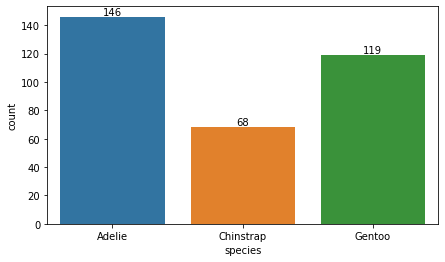

In [13]:
ax = sns.countplot(x="species", data = df)
ax.bar_label(ax.containers[0]);

# There is an inbalanced situation in the data, but we will decide whether 
# to treat the data as inbalanced or not after seeing the scores.

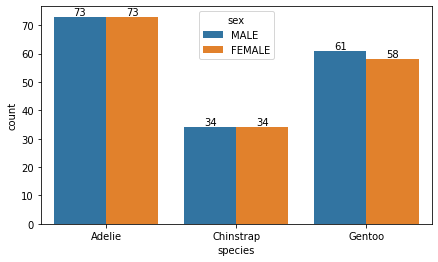

In [14]:
ax = sns.countplot(x="species", data = df, hue = "sex")
for p in ax.containers:
    ax.bar_label(p)

# distribution by gender

<Figure size 288x432 with 0 Axes>

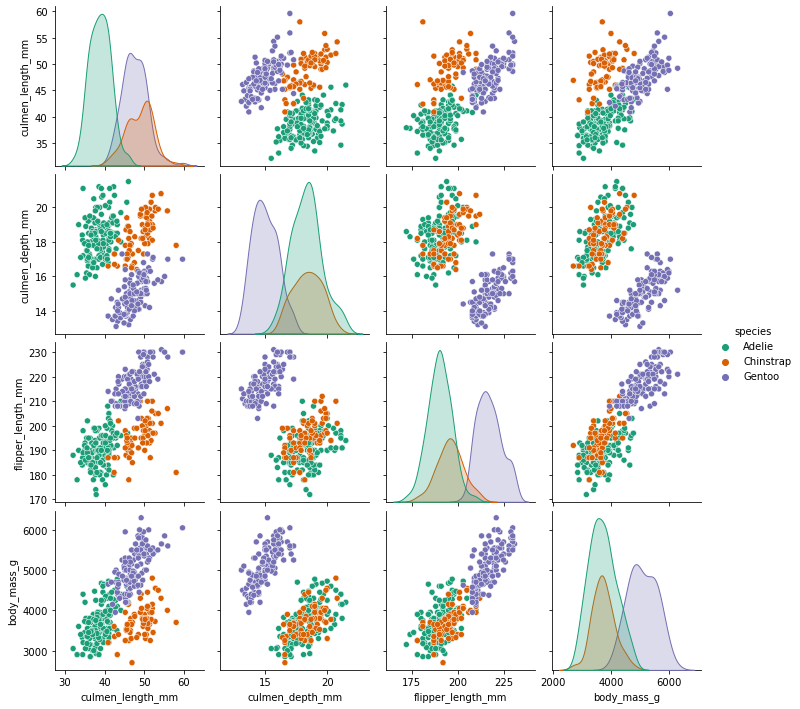

In [15]:
plt.figure(figsize=(4,6))
sns.pairplot(df,hue='species',palette='Dark2');

# Here, we can see how distinctive each feature is, but we can also see how the labels differ according to which features.

In [16]:
df.species.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

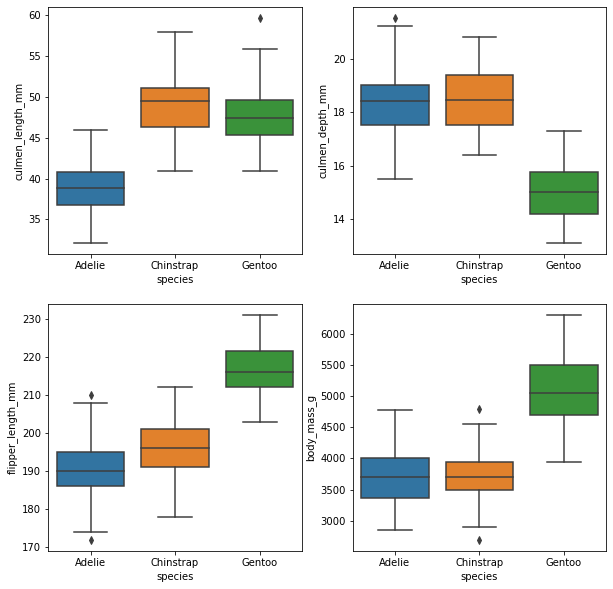

In [17]:
index = 0
plt.figure(figsize=(10,10))
for feature in df.select_dtypes("number"):
    if feature != "species":
        index += 1
        plt.subplot(2,2,index)
        sns.boxplot(x='species',y=feature,data=df)
        
# We can also get the insights here we got from the pair plot.

## Correlation beetwen numeric features

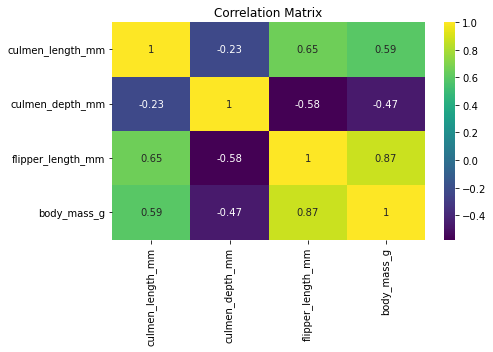

In [18]:
sns.heatmap(df.select_dtypes("number").corr(),annot=True, cmap='viridis')
plt.title("Correlation Matrix")

plt.show()

## Modeling with Pipeline

## Train | Test Split

In [19]:
X = df.drop(columns="species")
y = df['species']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In [21]:
cat = X_train.select_dtypes("object").columns
cat

Index(['island', 'sex'], dtype='object')

In [22]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder


ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat), 
                                        remainder='passthrough', 
                                        verbose_feature_names_out=False).set_output(transform="pandas")


# handle_unknown -> default is "error". If test data has any categorical data which doesn't exist in train data, 
# then the algorithm returns an error. Instead, we used "use_encoded_value" and -1 for the "unknown_value".
# Then unseen categorical data will be -1, and no error.

# remainder='pasthrough' will keep the numerical values without any modification

# attention! make_column_transformer changes the structure of data, order of features.
# first categorical, then numerical features.

# make_column_transformer generates output as array.we can transform it into df via set_output(transform=pandas)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


operations = [("OrdinalEncoder", column_trans), 
              ("RF_model", RandomForestClassifier(random_state=101))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)


Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('RF_model', RandomForestClassifier(random_state=101))])

## Model Performance on Classification Tasks

In [24]:
from sklearn.metrics import confusion_matrix, classification_report,\
                            accuracy_score, recall_score, precision_score,\
                            f1_score

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

# predict operation transforms the test data into numeric data by transforming it 
# according to the unique categorical data in the train data.

# Since make_column_transform is in the pipeline, the df structure is changed as 
# in the train data and sent to the relevant model to be predicted

### Random Forest

In [25]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

In [26]:
help(RandomForestClassifier)

# Differences from DT;
# 1. In addition to gini and entropy in criterion hyper parameter, 
# log_loss function used in logistic regression is included. The default is gini.

# 2. The max_features default is "sqrt". It takes the square root of the total 
# number of features in our data and converts the result to an integer number.

# 3. Random forest algorithms do not have a splitter hyper parameter. 
# Branches are always done according to the best feat. Not randomly selected

# 4. Added bootsrap hyper_pamat. Default is True. For each tree, it uses 
# approximately 2/3 of the observations in the train data with the random boostrap method.

# 5. With the oob_score hayper parameter, the performance of each tree is measured with 
# 1/3 of the observations allocated for each tree, and its feature importance is determined. 
# If you want to see oob_scores, we need to set this hyper parameter to True.

# 6. Both "balanced" and "balanced_subsaple" are available as class_weight hyper parameter.
# There is no "balanced_subsample" in DT. With "balanced" it weights according 
# to the total number of classes in the data, while with "balanced_subsaple" 
# it weights according to the number of classes in each tree.

# 7. With the max_samples hyper parameter, it trains with observations at the ratios 
# we choose (recommended 0.5, 0.8 ratios) to reduce the working cost of very large data.

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [27]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

# with default values, scores turned out much better than DT

Test_Set
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


Train_Set
[[117   0   0]
 [  0  54   0]
 [  0   0  95]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       117
   Chinstrap       1.00      1.00      1.00        54
      Gentoo       1.00      1.00      1.00        95

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



In [28]:
operations = [("OrdinalEncoder", column_trans), 
              ("RF_model", RandomForestClassifier(random_state=101))]

model = Pipeline(steps=operations)

scores = cross_validate(model, 
                        X_train, 
                        y_train, 
                        scoring=["accuracy", 
                                 "precision_micro", 
                                 "recall_micro", 
                                 "f1_micro"], 
                        cv = 10,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# no overfitting.

test_accuracy            0.992593
train_accuracy           1.000000
test_precision_micro     0.992593
train_precision_micro    1.000000
test_recall_micro        0.992593
train_recall_micro       1.000000
test_f1_micro            0.992593
train_f1_micro           1.000000
dtype: float64

## Evaluating ROC Curves and AUC

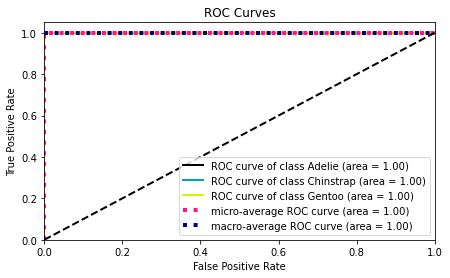

In [29]:
from scikitplot.metrics import plot_roc, precision_recall_curve

y_pred_probe = pipe_model.predict_proba(X_test)
    
plot_roc(y_test, y_pred_probe)
plt.show();

# model's overall performance is very high and naturally it is very successful in separating the classes from each other.

### RF Model Feature Importance

In [30]:
pipe_model["RF_model"].feature_importances_ # rf_model.feature_importances_Since we are using a # pipeline, we use pipe_model["DT_model"] to pull our ML model from inside the pipeline first, and then define the percentages as % for all featurs with the feature_importance_code, with a total of 1. The feature with the highest rating is the most important feature, while the feature with the lowest rating is the least important feature.


# Since the make_column_transformer function used in the pipe_model changes the order of features in df,
# the first 2 rates below belong to categorical featurs, while the next rates belong to numeric features.

# If the make_column_transformer was not used in the pipeline, df's feature order would not change.
# REMEMBER that the ordering changes only when the make_column_transformer function is used.

# feature importance is done after getting the best scores from the model. 
# Since I could get very high scores with the default hyperparameters of 
# the RF model for this data, we made feature importance without gridsearch. 
# However, we do not forget that we need to do feature importance over 
# the best hyper_paramtres we found after gridsearch.

array([0.1090312 , 0.01036703, 0.35052176, 0.15568431, 0.25091596,
       0.12347973])

In [31]:
features = pipe_model["OrdinalEncoder"].get_feature_names_out()
features

# The new feature order we got from pipe_model is as follows.

array(['island', 'sex', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g'], dtype=object)

In [32]:
rf_feature_imp = pd.DataFrame(data=pipe_model["RF_model"].feature_importances_, 
                              index = features, #index=X.columns
                              columns=["Feature Importance"])

rf_feature_imp = rf_feature_imp.sort_values("Feature Importance", ascending=False)
rf_feature_imp

,Feature Importance
culmen_length_mm,0.350522
flipper_length_mm,0.250916
culmen_depth_mm,0.155684
body_mass_g,0.123480
island,0.109031
sex,0.010367


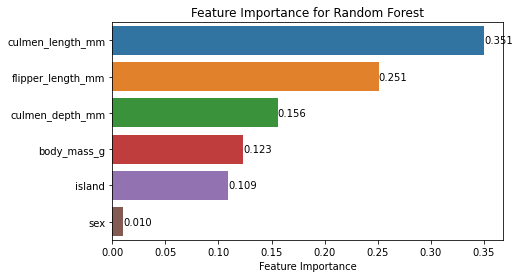

In [33]:
ax = sns.barplot(x=rf_feature_imp["Feature Importance"], 
                 y=rf_feature_imp.index)

ax.bar_label(ax.containers[0],fmt="%.3f")
plt.title("Feature Importance for Random Forest")
plt.show()

## Understanding Hyperparameters

In [34]:
from sklearn.tree import plot_tree

def report_model(model, number_of_tree):
    model_pred = model.predict(X_test)
    model_train_pred = model.predict(X_train)
    print('')
    print("Test Set")
    print(confusion_matrix(y_test, model_pred))
    print('')
    print(classification_report(y_test,model_pred))
    print('')
    print("Train Set")
    print(confusion_matrix(y_train, model_train_pred))
    print('')
    print(classification_report(y_train,model_train_pred))
    plt.figure(figsize=(12,8),dpi=100)
    plot_tree(model["RF_model"].estimators_[number_of_tree],
              feature_names=features, #features_names=X.columns
              class_names=df.species.unique(),
              filled = True,
              fontsize = 8);

# With the code model["RF_model"].estimators_[number_of_tree] we can visualize 
# the tree we want by giving the tree number (number_of_tree).

In [35]:
RF_model = RandomForestClassifier(random_state=101, 
                                  max_samples=0.5)

operations = [("OrdinalEncoder", column_trans), 
              ("RF_model", RF_model)]

pruned_tree = Pipeline(steps=operations) # pruned_tree = RandomForestClassifier(max_samples=0.5)

pruned_tree.fit(X_train,y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('RF_model',
                 RandomForestClassifier(max_samples=0.5, random_state=101))])


Test Set
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


Train Set
[[117   0   0]
 [  1  53   0]
 [  0   0  95]]

              precision    recall  f1-score   support

      Adelie       0.99      1.00      1.00       117
   Chinstrap       1.00      0.98      0.99        54
      Gentoo       1.00      1.00      1.00        95

    accuracy                           1.00       266
   macro avg       1.00      0.99      1.00       266
weighted avg       1.00      1.00      1.00       266



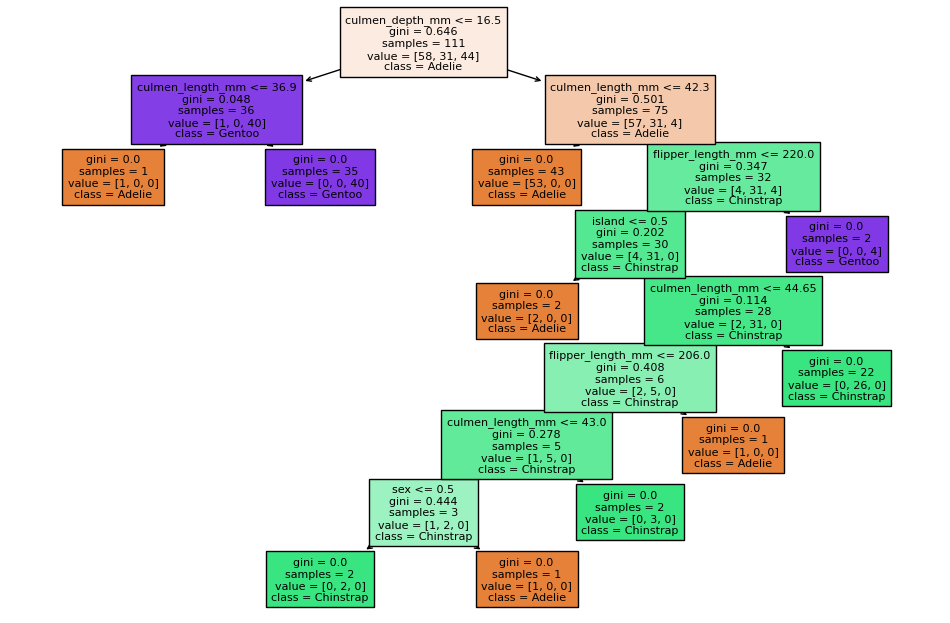

In [36]:
report_model(pruned_tree, 2)

# 266*2/3 = 177.33

# About 2/3 of the 266 observations in train data are used on each tree. As you can see in this tree,
# an observation close to this ratio was used.

## Final Model and Prediction

In [37]:
X = df.drop(columns=["species"])
y = df['species']

In [38]:
X.head(2)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE


In [39]:
operations = [("transformer", column_trans),
              ("RF", RandomForestClassifier(random_state=11))]
pipe_model = Pipeline(steps=operations)
pipe_model.fit(X, y)

# Since our scores are very good, we did not do gridsearch, we will do gridsearch 
# in the diabetes dataset we will solve below.

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['island', 'sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('RF', RandomForestClassifier(random_state=11))])

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,333.0,43.992793,5.468668,32.1,39.5,44.5,48.6,59.6
culmen_depth_mm,333.0,17.164865,1.969235,13.1,15.6,17.3,18.7,21.5
flipper_length_mm,333.0,200.966967,14.015765,172.0,190.0,197.0,213.0,231.0
body_mass_g,333.0,4207.057057,805.215802,2700.0,3550.0,4050.0,4775.0,6300.0


In [41]:
observations = {"island": ["Torgersen", "Biscoe"], 
                "culmen_length_mm":[39, 48], 
                "culmen_depth_mm":[18, 14],
                "flipper_length_mm":[180, 213], 
                "body_mass_g":[3700, 4800], 
                "sex":["MALE", "FEMALE"]}

obs = pd.DataFrame(observations)
obs

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39,18,180,3700,MALE
1,Biscoe,48,14,213,4800,FEMALE


In [42]:
pipe_model.predict(obs)

array(['Adelie', 'Gentoo'], dtype=object)

# DT and RF Scoring for diabetes dataset

In [43]:
df = pd.read_csv("diabetes.csv")

In [44]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Cleaning Outliers

In [45]:
df=df[df.SkinThickness<70]
df=df[df.Glucose>0]
df=df[df.BloodPressure>35]
df=df[df.BMI>0]

# droping the outliers we found in earlier sessions

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               720 non-null    int64  
 1   Glucose                   720 non-null    int64  
 2   BloodPressure             720 non-null    int64  
 3   SkinThickness             720 non-null    int64  
 4   Insulin                   720 non-null    int64  
 5   BMI                       720 non-null    float64
 6   DiabetesPedigreeFunction  720 non-null    float64
 7   Age                       720 non-null    int64  
 8   Outcome                   720 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.2 KB


<AxesSubplot:ylabel='Outcome'>

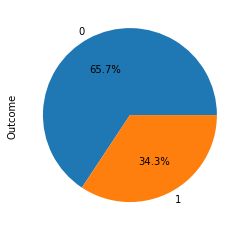

In [47]:
df.Outcome.value_counts().plot(kind="pie", autopct='%1.1f%%')

## Train | Test Split and Scalling

In [48]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

## Modelling and Model Performance

### Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=101)
dt_model.fit(X_train, y_train)
eval_metric(dt_model, X_train, y_train, X_test, y_test)

# Since our data is unbalanced and my target label has a bad score, I used class_weight = "balanced" directly.
# There is no need to assign class_weight to gridsearch in unbalanced datasets.

Test_Set
[[75 20]
 [23 26]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        95
           1       0.57      0.53      0.55        49

    accuracy                           0.70       144
   macro avg       0.67      0.66      0.66       144
weighted avg       0.70      0.70      0.70       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [51]:
model = DecisionTreeClassifier(class_weight="balanced", random_state=101)


scores = cross_validate(model, 
                        X_train, 
                        y_train, 
                        scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = 10, 
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# confirm the overfitting

test_accuracy      0.711766
train_accuracy     1.000000
test_precision     0.589251
train_precision    1.000000
test_recall        0.551316
train_recall       1.000000
test_f1            0.565202
train_f1           1.000000
dtype: float64

In [52]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 2, 3],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [2, 3,4,5]}

In [53]:
model = DecisionTreeClassifier(class_weight="balanced", random_state=101)


dt_grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='recall',
                            cv=10,
                            n_jobs=-1 
                            ).fit(X_train, y_train)

In [54]:
dt_grid_model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       random_state=101, splitter='random')

In [55]:
eval_metric(dt_grid_model, X_train, y_train, X_test, y_test)

# There seems to be no overfitting but we will make our final confirmation in the CV.

# Our target class We will compare the 1 scores in the test data with the average 
# value of the validation sets we will get from the CV and confirm our score.

Test_Set
[[33 62]
 [ 5 44]]
              precision    recall  f1-score   support

           0       0.87      0.35      0.50        95
           1       0.42      0.90      0.57        49

    accuracy                           0.53       144
   macro avg       0.64      0.62      0.53       144
weighted avg       0.71      0.53      0.52       144


Train_Set
[[133 245]
 [  8 190]]
              precision    recall  f1-score   support

           0       0.94      0.35      0.51       378
           1       0.44      0.96      0.60       198

    accuracy                           0.56       576
   macro avg       0.69      0.66      0.56       576
weighted avg       0.77      0.56      0.54       576



In [56]:
model = DecisionTreeClassifier(class_weight='balanced',
                               max_depth=2,
                               min_samples_leaf=2,
                               random_state=101,
                               splitter='random')

scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        cv=10,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# No overfitting. The scores of the 1 class in the test data and the scores of the validation set are consistent.

test_accuracy      0.559074
train_accuracy     0.563274
test_precision     0.437143
train_precision    0.438265
test_recall        0.959474
train_recall       0.959595
test_f1            0.600060
train_f1           0.601704
dtype: float64

In [57]:
from sklearn.metrics import precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay, \
                            roc_auc_score, roc_curve, average_precision_score
#plot_precision_recall_curve, plot_roc_curve

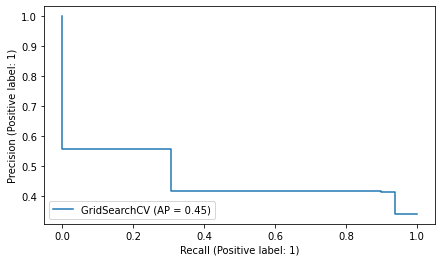

In [58]:
PrecisionRecallDisplay.from_estimator(dt_grid_model, X_test, y_test);

# the overall performance of the model is too low.

### Random Forest

In [59]:
rf_model = RandomForestClassifier(class_weight="balanced", 
                                  random_state=101)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=101)

In [60]:
eval_metric(rf_model, X_train, y_train, X_test, y_test)

# presence of overfitting

Test_Set
[[83 12]
 [24 25]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        95
           1       0.68      0.51      0.58        49

    accuracy                           0.75       144
   macro avg       0.73      0.69      0.70       144
weighted avg       0.74      0.75      0.74       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [61]:
model = RandomForestClassifier(class_weight="balanced", 
                               random_state=101)

scores = cross_validate(model, 
                        X_train,
                        y_train, 
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        cv = 10,
                       return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# overfiting confirmed.

test_accuracy      0.763944
train_accuracy     1.000000
test_precision     0.702761
train_precision    1.000000
test_recall        0.570000
train_recall       1.000000
test_f1            0.616765
train_f1           1.000000
dtype: float64

## GridSearch

In [62]:
param_grid = {'n_estimators':[64, 128, 200],
             'max_features':[2, 4, 'sqrt'],
             'max_depth':[2, 3, 4],
             'min_samples_split':[2, 3,4],
             'min_samples_leaf': [2,3,4],
             'max_samples':[0.8, 1]} # add 1

In [63]:
model = RandomForestClassifier(class_weight={0:1, 1:4},
                               random_state=101)
rf_grid_model = GridSearchCV(model,
                             param_grid,
                             scoring="recall",
                             n_jobs = -1,
                             verbose=2).fit(X_train, y_train)

# I weighted it 1 to 4 because class_weight="balanced" was insufficient.

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] E

[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=

[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=64; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2,

[CV] END max_depth=2, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=4, max_samples=1, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=4, max_samples=1, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=4, max_samples=1, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=4, max_samples=1, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=4, max_samples=1, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=4, max_samples=1, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=4, max_samples=1, min_samples_leaf=3, min_samp

[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=

[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.4s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=

[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=64; total time=   0.1s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_leaf=3, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=2, max_features=2, max_samples=0.8, min_samples_lea

[CV] END max_depth=3, max_features=2, max_samples=0.8, min_samples_leaf=4, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samp

[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=3, n_estimators=64; total time=   0.1s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=4, n_estimators=64; total time=   0.1s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=4, n_estimators=64; total time=   0.1s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_s

In [64]:
rf_grid_model.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=2, max_features=2,
                       max_samples=0.8, min_samples_leaf=2, n_estimators=64,
                       random_state=101)

In [65]:
rf_grid_model.best_score_

0.9597435897435898

In [66]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

# the overfiting seems to have been fixed but we will make our final confirmation in the CV.

# We will confirm the score by comparing the class 1 scores in the Test data of our target class 
# with the average value of the validation sets we will get from the CV.

Test_Set
[[45 50]
 [ 5 44]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62        95
           1       0.47      0.90      0.62        49

    accuracy                           0.62       144
   macro avg       0.68      0.69      0.62       144
weighted avg       0.75      0.62      0.62       144


Train_Set
[[154 224]
 [  3 195]]
              precision    recall  f1-score   support

           0       0.98      0.41      0.58       378
           1       0.47      0.98      0.63       198

    accuracy                           0.61       576
   macro avg       0.72      0.70      0.60       576
weighted avg       0.80      0.61      0.60       576



In [67]:
model = RandomForestClassifier(class_weight={0: 1, 1: 4},
                               max_depth=2,
                               max_features=2,
                               max_samples=0.8,
                               min_samples_leaf=2,
                               n_estimators=64,
                               random_state=101)

scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        cv=10,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# I have confirmed that there is no overfitting. 
# The scores of the 1 class in the test data and the scores of the validation set are consistent.

test_accuracy      0.604144
train_accuracy     0.614193
test_precision     0.464524
train_precision    0.470670
test_recall        0.965000
train_recall       0.979242
test_f1            0.626629
train_f1           0.635736
dtype: float64

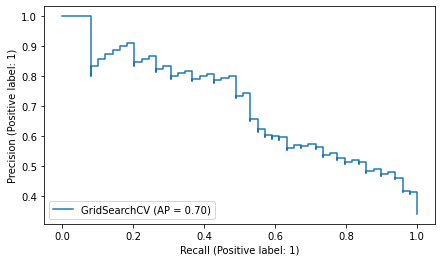

[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=4, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=4, min_samples

[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=128; total time=   0.3s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.4s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=3, min_samples_split=4, n_estimators=64; total time=   0.1s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf

[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.4s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=2, n_estimators=64; total time=   0.1s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=4, n_estimators=64; total time=   0.1s
[CV] END max_depth=4, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=4, n_estimators=128; total time=   0.3s
[CV] END max_depth=4, max_features=4, max_samples=1, min_samples_leaf=2,

[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=3, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=3, min_samples_split=4, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=4, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=4, min_samples_split=2, n_estimators=128; total time=   0.2s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=3, max_features=2, max_samples=1, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=3, max_features=4, max_samples=0.8, min_samples_leaf=2, min_samp

In [68]:
PrecisionRecallDisplay.from_estimator(rf_grid_model, X_test, y_test);

# The overall performance of the RF model is much better than the DT